In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(f"TensorFlow/Keras version: {tf.__version__} / {keras.__version__}")

TensorFlow/Keras version: 2.12.0 / 2.12.0


In [2]:
# Created by Pascal Niemann
# vgg_small - 150 epochs loss: 0.2810 - accuracy: 0.9155
# Total params: 993,426
# Trainable params: 991,870
# Non-trainable params: 1,556

In [3]:
# build CNN using Keras Functional API - Oriented VGG16 Architecture. Limited to 1 Mio Param
def vgg_small(input_shape, num_classes):
    seed = 0
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # define activations and initializers
    activation = keras.activations.relu
    initializer = keras.initializers.HeNormal
    output_activation = keras.activations.softmax
    output_initializer = keras.initializers.GlorotNormal
    kernel=3

    input1 = keras.layers.Input(shape=input_shape)
    
    conv = keras.layers.Conv2D(32, kernel_size=kernel, padding="same", kernel_initializer=initializer)(input1)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation(activation)(conv)
    conv0 = keras.layers.Conv2D(32, kernel_size=kernel, padding="same", kernel_initializer=initializer)(conv)
    conv0 = keras.layers.BatchNormalization()(conv0)
    conv0 = keras.layers.Activation(activation)(conv0)
    pool = keras.layers.MaxPooling2D((2,2),strides=2)(conv0)

    conv1 = keras.layers.Conv2D(64, kernel_size=kernel, padding="same", kernel_initializer=initializer)(pool)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation)(conv1)
    conv1 = keras.layers.Dropout(rate=0.3)(conv1)
    conv2 = keras.layers.Conv2D(128, kernel_size=kernel, padding="same", kernel_initializer=initializer)(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation(activation)(conv2)
    pool2 = keras.layers.MaxPooling2D((2,2),strides=2)(conv2)

    conv3 = keras.layers.Conv2D(256, kernel_size=kernel, padding="same", kernel_initializer=initializer)(pool2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation(activation)(conv3)
    conv3 = keras.layers.Dropout(rate=0.3)(conv3)
    conv4 = keras.layers.Conv2D(256, kernel_size=kernel, padding="same", kernel_initializer=initializer)(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.Activation(activation)(conv4)
    pool3 = keras.layers.MaxPooling2D((2,2),strides=2)(conv4)
    pool4 = keras.layers.GlobalAveragePooling2D()(pool3)
    
    output1 = keras.layers.Dense(10,kernel_initializer=output_initializer)(pool4)
    output1 = keras.layers.BatchNormalization()(output1)
    output1 = keras.layers.Activation(output_activation)(output1)
    
    return keras.Model(inputs=[input1], outputs=[output1])

In [4]:
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 100:
        lr *= 0.1
    elif epoch > 50:
        lr *= 0.5
    return lr

In [5]:
# callbacks for model saving and for learning rate adjustment.
checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callback = [checkpoint, lr_reducer, lr_scheduler]

In [6]:
# Load Dataset
y_labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# normalize pixel values to [0,1]
X_train = x_train / 255
X_test = x_test / 255

# one-hot encoding for class labels
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

170498071/170498071 [==============================] - 11s 0us/step


In [7]:
model = vgg_small(x_train[0].shape, 10)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                             

In [8]:
##HyperParameter
batch_size = 16
epoch = 150

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

it_train = datagen.flow(X_train, y_train, batch_size=batch_size)

hist = model.fit(it_train, epochs=epoch,validation_data=(X_val, y_val),callbacks=[callback])

Epoch 1/150
2813/2813 [==============================] - 64s 17ms/step - loss: 1.4722 - accuracy: 0.4832 - val_loss: 1.3903 - val_accuracy: 0.5076 - lr: 0.0010
Epoch 2/150
2813/2813 [==============================] - 48s 17ms/step - loss: 1.1534 - accuracy: 0.5992 - val_loss: 1.2174 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 3/150
2813/2813 [==============================] - 47s 17ms/step - loss: 1.0098 - accuracy: 0.6510 - val_loss: 0.8857 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 4/150
2813/2813 [==============================] - 46s 16ms/step - loss: 0.9116 - accuracy: 0.6877 - val_loss: 0.6934 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 5/150
2813/2813 [==============================] - 47s 17ms/step - loss: 0.8463 - accuracy: 0.7130 - val_loss: 0.7706 - val_accuracy: 0.7398 - lr: 0.0010
Epoch 6/150
2813/2813 [==============================] - 47s 17ms/step - loss: 0.7909 - accuracy: 0.7313 - val_loss: 0.6109 - val_accuracy: 0.7908 - lr: 0.0010
Epoch 7/150
2813/2813 [=================

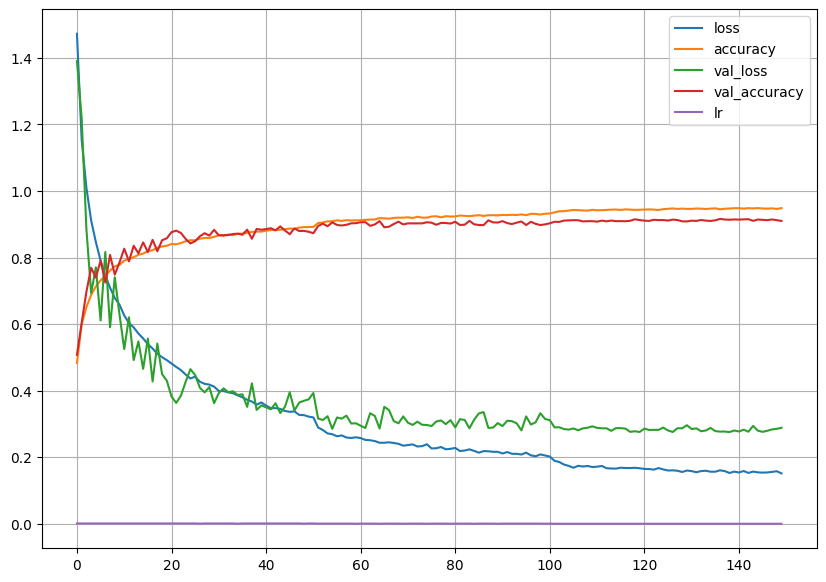

In [10]:
pd.DataFrame(hist.history).plot(figsize=(10, 7))
plt.grid(True)
plt.show()

In [11]:
model.load_weights(checkpoint_filepath)
model.evaluate(X_test, y_test, batch_size=batch_size)

625/625 [==============================] - 3s 4ms/step - loss: 0.2811 - accuracy: 0.9155


[0.2811231017112732, 0.9154999852180481]

In [12]:
# get predicted class label in human-readable form (decode one-hot encoding)
def get_class_label(y):
    if y.ndim == 1:
        return np.argmax(y)
    else:
        return np.argmax(y, axis=1)

# find mis-classified test images
y_pred = model.predict(X_test)
error_ids = np.where(get_class_label(y_pred) != get_class_label(y_test))
print(f"Misclassified: {error_ids[0].size} / {X_test.shape[0]}")

313/313 [==============================] - 1s 3ms/step
Misclassified: 845 / 10000


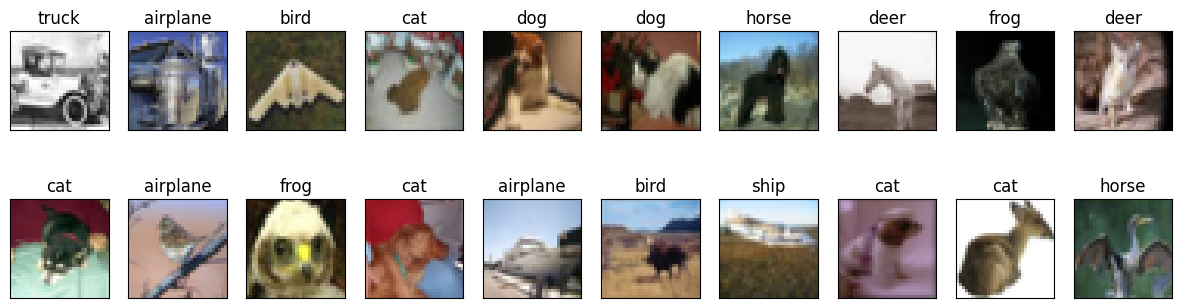

In [13]:
# show a few misclassified test images with estimated class labels
fig = plt.figure(figsize=(15, 4))
for error_id in range(20):
    id = error_ids[0][error_id]
    ax = fig.add_subplot(2, 10, error_id + 1, xticks=[], yticks=[], title=y_labels[int(get_class_label(y_pred[id]))])
    ax.imshow(X_test[id], interpolation='none')
plt.show()